In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch import nn
from torch import Tensor
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor
from einops import rearrange, reduce, repeat
from einops.layers.torch import Rearrange, Reduce
from torchsummary import summary

In [2]:
pip install einops

Note: you may need to restart the kernel to use updated packages.


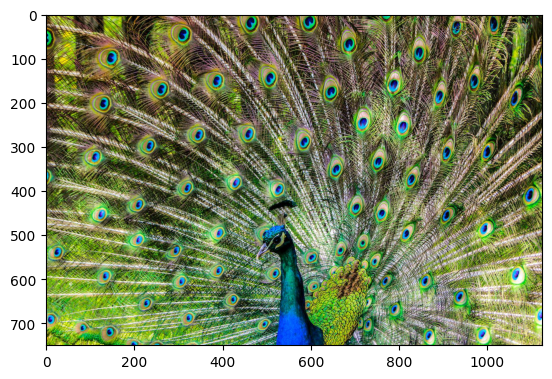

In [3]:
img = Image.open('peacock-pen-alluring-yet-lure-65894.jpeg')

fig = plt.figure()
plt.imshow(img)

In [4]:
transform=Compose([Resize((224,224)),ToTensor()])
x=transform(img)
x=x.unsqueeze(0)
x.shape

torch.Size([1, 3, 224, 224])

In [5]:
patch_size=16
patches = rearrange(x, 'b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size)
patches.size()

torch.Size([1, 196, 768])

In [6]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h s1) (w s2) -> b (h w) (s1 s2 c)', s1=patch_size, s2=patch_size),
            nn.Linear(patch_size * patch_size * in_channels, emb_size)
        )
                
    def forward(self, x: Tensor) -> Tensor:
        x = self.projection(x)
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 196, 768])

In [7]:
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels: int = 3, patch_size: int = 16, emb_size: int = 768,img_size:int=224):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # using a conv layer instead of a linear one -> performance gains
            nn.Conv2d(in_channels, emb_size, kernel_size=patch_size, stride=patch_size),
            Rearrange('b e (h) (w) -> b (h w) e'),
        )
        self.class_token=nn.Parameter(torch.randn(1,1,emb_size))
        self.positions = nn.Parameter(torch.randn((img_size // patch_size) **2 + 1, emb_size))

    def forward(self, x: Tensor) -> Tensor:
        b,_,_,_=x.shape
        x = self.projection(x)
        cls_tokens=repeat(self.class_token,'() n e ->b n e ',b=b)
        x=torch.cat([cls_tokens,x],dim=1)
        x+=self.positions
        return x
    
PatchEmbedding()(x).shape

torch.Size([1, 197, 768])

In [8]:
class MultiHeadAttention(nn.Module):
    def __init__(self, emb_size: int = 768, num_heads: int = 8, dropout: float = 0):
        super().__init__()
        self.emb_size = emb_size
        self.num_heads = num_heads
        self.keys = nn.Linear(emb_size, emb_size)
        self.queries = nn.Linear(emb_size, emb_size)
        self.values = nn.Linear(emb_size, emb_size)
        self.att_drop = nn.Dropout(dropout)
        self.projection = nn.Linear(emb_size, emb_size)
    def forward(self,x:Tensor,mask:Tensor=None)-> Tensor:
        p=self.queries(x)
        
        queries=rearrange(self.queries(x),"b n (h d) -> b h n d",h=self.num_heads)
        keys=rearrange(self.keys(x),'b n (h d)-> b h n d',h=self.num_heads)
        values=rearrange(self.values(x),'b n (h d)-> b h n d',h=self.num_heads)
        energy=torch.einsum('b h q d,b h k d -> b h q k', queries,keys)
        if mask is not None:
            fill_value = torch.finfo(torch.float32).min
            energy.mask_fill(~mask, fill_value)
        scaling=self.emb_size**(1/2)
        att=F.softmax(energy,dim=-1)/scaling
        att=self.att_drop(att)
        out=torch.einsum('b h a l,b h l v -> b h a v',att,values)
        out=rearrange(out,"b h n d -> b n (h d)")
        out=self.projection(out)
        return out 
    





In [9]:
patches_embed=PatchEmbedding()(x)
MultiHeadAttention()(patches_embed).shape

torch.Size([1, 197, 768])

In [10]:
class residual(nn.Module):
    def __init__(self,fn):
        super().__init__()
        self.fn=fn

    def forward(self,x,**kwargs):
        res=x
        x=self.fn(x,**kwargs)
        x+=res
        return x

In [11]:
class FeedForward(nn.Module):
    def __init__(self, emb_size: int, expansion: int = 4, drop_p: float = 0.):
        super(FeedForward, self).__init__()
        
        self.linear1 = nn.Linear(emb_size, expansion * emb_size)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(drop_p)
        self.linear2 = nn.Linear(expansion * emb_size, emb_size)

    def forward(self, x):
        x = self.linear1(x)
        x = self.gelu(x)
        x = self.dropout(x)
        x = self.linear2(x)
        return x


In [12]:
class TranformerEncoderBlock(nn.Module):
    def __init__(self, emb_size: int = 768,
                 drop_p: float = 0.,
                 forward_expansion: int = 4,
                 forward_drop_p: float = 0.,
                 **kwargs):
        super(TranformerEncoderBlock, self).__init__()
        
        self.norm1 = nn.LayerNorm(emb_size)
        self.attention = MultiHeadAttention(emb_size, **kwargs)
        self.dropout1 = nn.Dropout(drop_p)
        
        self.norm2 = nn.LayerNorm(emb_size)
        self.feedforward = FeedForward(emb_size, **kwargs)
        self.dropout2 = nn.Dropout(drop_p)
        
    def forward(self, x):
        # First residual connection
        residual1 = x
        x = self.norm1(x)
        x = self.attention(x)
        x = self.dropout1(x)
        x += residual1
        
        # Second residual connection
        residual2 = x
        x = self.norm2(x)
        x = self.feedforward(x)
        x = self.dropout2(x)
        x += residual2
        
        return x


In [13]:
patches_embed=PatchEmbedding()(x)
TranformerEncoderBlock()(patches_embed).shape

torch.Size([1, 197, 768])

In [14]:
class encoder(nn.Module):
    def __init__(self, depth: int = 12, **kwargs):
        super(encoder, self).__init__()
        
        # Store the transformer encoder blocks in a ModuleList
        self.blocks = nn.ModuleList([TranformerEncoderBlock(**kwargs) for _ in range(depth)])

    def forward(self, x):
        for block in self.blocks:
            x = block(x)
        return x


In [15]:
class clasification(nn.Module):
    def __init__(self, emb_size: int = 768, n_classes: int = 6):
        super(clasification, self).__init__()
        
        self.reduce = Reduce('b n e -> b e', reduction='mean')
        self.layer_norm = nn.LayerNorm(emb_size)
        self.linear = nn.Linear(emb_size, n_classes)

    def forward(self, x):
        x = self.reduce(x)
        x = self.layer_norm(x)
        x = self.linear(x)
        return x


In [16]:
class ViT(nn.Module):
    def __init__(self,     
                in_channels: int = 3,
                patch_size: int = 16,
                emb_size: int = 768,
                img_size: int = 224,
                depth: int = 12,
                n_classes: int = 6,
                **kwargs):
        super(ViT, self).__init__()
        
        self.patch_embedding = PatchEmbedding(in_channels, patch_size, emb_size, img_size)
        self.encoder = encoder(depth, emb_size=emb_size, **kwargs)
        self.classification = clasification(emb_size, n_classes)

    def forward(self, x):
        x = self.patch_embedding(x)
        x = self.encoder(x)
        x = self.classification(x)
        return x


In [17]:
import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define data augmentation transformations
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),

    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),

    transforms.ToTensor(),

    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Create train and test datasets
path = "/home/accl/Desktop/borescope-adr-lm2500-data-develop/preprocessed"
train_dataset = ImageFolder(root='/home/accl-ros/borescope-adr-lm2500-data-develop/dataset_5/images/object3/', transform=data_transforms)
test_dataset = ImageFolder(root='/home/accl-ros/borescope-adr-lm2500-data-develop/dataset_5/images/test_object/', transform=data_transforms)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=40, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=28, shuffle=True, num_workers=5)

In [18]:
def check_balance(train_loader):
    class_count = {}
    for _, labels in train_loader:
        for label in labels:
            if label.item() not in class_count:
                class_count[label.item()] = 0
            class_count[label.item()] += 1
    print(check_balance)
    return(class_count)

# Assume you have a DataLoader object named train_loader
class_count=check_balance(train_loader)


<function check_balance at 0x7f2a7474b760>


In [19]:
from torch.utils.data import DataLoader, ConcatDataset, Subset
from torchvision import transforms
from torch.utils.data import random_split


imbalance_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),

    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


target_samples_per_class = max(class_count.values())


indices_per_class = {i: [] for i in class_count.keys()}
for idx, (_, label) in enumerate(train_dataset):
    indices_per_class[label].append(idx)


datasets = []


for class_label, indices in indices_per_class.items():
    
    extra_samples = target_samples_per_class - len(indices)

    
    class_subset = Subset(train_dataset, indices)

   
    class_subset.dataset.transform = imbalance_transforms

    
    class_datasets = [class_subset] * (1 + extra_samples // len(indices))

    
    if extra_samples % len(indices) != 0:
        extra_subset = Subset(class_subset, range(extra_samples % len(indices)))
        class_datasets.append(extra_subset)

    
    class_dataset = ConcatDataset(class_datasets)

    
    datasets.append(class_dataset)


balanced_dataset = ConcatDataset(datasets)
length = len(balanced_dataset)
train_proportion = 0.87
train_len = int(length * train_proportion)
valid_len = length - train_len
balanced_train_data, balanced_valid_data = random_split(balanced_dataset, [train_len, valid_len])
balanced_train_loader = DataLoader(balanced_train_data, batch_size=140, shuffle=True)
balanced_valid_loader = DataLoader(balanced_valid_data, batch_size=100, shuffle=True)


In [20]:
from GPUtil import showUtilization as gpu_usage
gpu_usage()
def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()

free_gpu_cache()

| ID | GPU | MEM |
------------------
|  0 |  0% |  5% |
|  1 |  0% |  0% |
Initial GPU Usage
| ID | GPU | MEM |
------------------
|  0 |  0% |  5% |
|  1 |  0% |  0% |


NameError: name 'cuda' is not defined

In [ ]:

# Import necessary libraries
import torch
import torchvision
import torchvision.transforms as transforms

# Set up transformations: Convert images to tensor and normalize
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the dataset to [-1, 1] range for all RGB channels
])

# Download and load the training dataset
train_datasetc = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
train_loaderc= torch.utils.data.DataLoader(train_dataset, batch_size=100, shuffle=True, num_workers=2)

# Download and load the test dataset
test_datasetc = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
test_loaderc = torch.utils.data.DataLoader(test_dataset, batch_size=100, shuffle=False, num_workers=2)

# Display the class labels
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import warnings
warnings.filterwarnings('ignore')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = ViT(in_channels=3, patch_size=16, emb_size=768, img_size=224, depth=12, n_classes=10).to(device)

#if torch.cuda.device_count() > 1:
  #model = nn.DataParallel(model)

#
# Loss and Optimizer
if torch.cuda.device_count() > 1:
  model = nn.DataParallel(model)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
train_accuracies = []

for epoch in range(300):

    running_loss = 0.0
    correct_predictions = 0
    total_predictions = 0
    patience=10
    stop_count = 0
    min_valid_loss = float('inf')
    model.train()

    for i, data in enumerate(train_loaderc, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 25== 24:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

    epoch_loss = running_loss / len(train_loaderc)
    epoch_accuracy = 100 * correct_predictions / total_predictions
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%')
    model.eval()
    valid_loss = 0.0
    for i, data in enumerate(test_loaderc, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)


        optimizer.zero_grad()


        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total_predictions += labels.size(0)
        correct_predictions += (predicted == labels).sum().item()

        loss = criterion(outputs, labels)
        valid_loss += loss.item()
    valid_loss /= len(test_loaderc.dataset)

    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 500, valid_loss))

    # Check for Early Stopping
    if valid_loss < min_valid_loss:
        min_valid_loss = valid_loss
        stop_count = 0
    else:
        stop_count += 1
        if stop_count >= patience:
            print("Early stopping")
            break

[1,    25] loss: 0.248
[1,    50] loss: 0.210
Epoch 1, Loss: 0.029608873759998995, Accuracy: 25.433871932974267%
Epoch [1/500], Loss: 0.0189
[2,    25] loss: 0.205
[2,    50] loss: 0.202
Epoch 2, Loss: 0.02847544118469837, Accuracy: 27.169359664871333%
Epoch [2/500], Loss: 0.0189
[3,    25] loss: 0.198
[3,    50] loss: 0.202
Epoch 3, Loss: 0.037139305881425444, Accuracy: 29.3836026331538%
Epoch [3/500], Loss: 0.0189
[4,    25] loss: 0.200
[4,    50] loss: 0.196
Epoch 4, Loss: 0.025142779537275724, Accuracy: 30.839816477159385%
Epoch [4/500], Loss: 0.0183
[5,    25] loss: 0.195
[5,    50] loss: 0.195
Epoch 5, Loss: 0.03298645861008588, Accuracy: 33.31338519848394%
Epoch [5/500], Loss: 0.0194
[6,    25] loss: 0.198
[6,    50] loss: 0.193
Epoch 6, Loss: 0.02795063748079188, Accuracy: 32.43566726511071%
Epoch [6/500], Loss: 0.0181
[7,    25] loss: 0.196
[7,    50] loss: 0.193
Epoch 7, Loss: 0.03273967668121936, Accuracy: 34.270895671254735%
Epoch [7/500], Loss: 0.0175
[8,    25] loss: 0.19

KeyboardInterrupt: 

In [ ]:
model.eval()
valid_loss = 0.0
correct_predictions = 0
total_predictions = 0
patience=10
stop_count = 0
for i, data in enumerate(test_loaderc, 0):
    # get the inputs; data is a list of [inputs, labels]
    inputs, labels = data[0].to(device), data[1].to(device)


    optimizer.zero_grad()


    outputs = model(inputs)
    _, predicted = torch.max(outputs.data, 1)
    total_predictions += labels.size(0)
    correct_predictions += (predicted == labels).sum().item()

    loss = criterion(outputs, labels)
    valid_loss += loss.item()
valid_loss /= len(test_loaderc.dataset)
epoch_loss = running_loss / len(train_loaderc)
epoch_accuracy = 100 * correct_predictions / total_predictions
train_losses.append(epoch_loss)
train_accuracies.append(epoch_accuracy)

print(f'Epoch {epoch+1}, Loss: {epoch_loss}, Accuracy: {epoch_accuracy}%')


Epoch 450, Loss: 0.029866396212110333, Accuracy: 28.07017543859649%
